# DAY 45 预训练模型


## 1. 预训练的概念与动机
在深度学习训练中，参数的**初始值**会显著影响收敛速度与最终效果。
如果能从一个更合理的起点开始，往往可以：
- 更快收敛，减少训练轮次
- 降低陷入差的局部最优的概率


### 1.1 为什么预训练有效？
预训练模型通常在**规模更大、类别更丰富**的数据集上学习到通用特征。
这些特征可以迁移到新的任务中继续微调，从而提升性能。

常见理解：
1. **任务相似性**：上游任务与下游任务越接近，迁移越有效。
2. **大规模数据优势**：数据越多、分布越丰富，学到的特征越通用。


### 1.2 迁移学习与微调
- **上游任务**：在大规模数据集上训练模型（得到预训练权重）。
- **下游任务**：在自己的数据集上继续训练以适配新任务。
- **微调（Fine-tuning）**：用预训练权重初始化模型并继续训练。


### 1.3 CIFAR-10 为什么不适合作为预训练数据集
- **规模较小**：只有 10 万张、尺寸 32x32，难以支撑复杂模型学习通用特征。
- **类别较少**：仅 10 类，泛化能力受限。

常见预训练数据集：**ImageNet**
- 1000 类、120 万张图像
- 典型输入尺寸 224x224
- 官网：http://www.image-net.org/


## 2. 经典预训练模型家族
### 2.1 CNN 架构
| 模型 | 预训练数据集 | 核心特点 | CIFAR-10 适配要点 |
|---|---|---|---|
| **AlexNet** | ImageNet | 首次引入 ReLU/局部响应归一化，参数量 60M+ | 调整首层卷积核大小以适配小图 |
| **VGG16** | ImageNet | 纯卷积堆叠、结构统一 | 常见做法：冻结前几层，仅微调后层 |
| **ResNet18** | ImageNet | 残差连接缓解梯度消失 | 直接适配 32x32，必要时调整池化层 |
| **MobileNetV2** | ImageNet | 深度可分离卷积，轻量高效 | 适合算力受限场景 |

### 2.2 Transformer 类
适用于更大图像（如 224x224），CIFAR-10 往往需要**上采样**或调整 Patch 大小。
| 模型 | 预训练数据集 | 核心特点 | CIFAR-10 适配要点 |
|---|---|---|---|
| **ViT-Base** | ImageNet-21K | 纯 Transformer 架构 | Resize 到 224x224，Patch 适当缩小 |
| **Swin Transformer** | ImageNet-22K | 分层窗口注意力 | 调整窗口大小适配小图像 |
| **DeiT** | ImageNet | 轻量 Transformer | 适合中小图像场景 |

### 2.3 自监督预训练
无需人工标注，通过 pretext task 学习表征，适合标签稀缺场景。
| 模型 | 预训练方式 | 典型数据集 | 适用优势 |
|---|---|---|---|
| **MoCo v3** | 对比学习 | ImageNet | 标签少也能迁移 |
| **BEiT** | 掩码图像建模 | ImageNet-22K | 语义特征强、微调收敛快 |


## 3. 常见分类预训练模型发展
### 3.1 发展脉络
| 模型 | 年份 | 关键创新 | 层数 | 参数量 | ImageNet Top-5 错误率 |
|---|---|---|---|---|---|
| **LeNet-5** | 1998 | 早期 CNN 架构 | 7 | ~60K | N/A |
| **AlexNet** | 2012 | ReLU/Dropout/GPU 训练 | 8 | 60M | 15.3% |
| **VGGNet** | 2014 | 统一 3x3 卷积核 | 16/19 | 138M+ | 7.3% |
| **GoogLeNet** | 2014 | Inception 多分支 | 22 | 5M | 6.7% |
| **ResNet** | 2015 | 残差连接 | 18/50/152 | 11M-60M | 3.57% |
| **DenseNet** | 2017 | 密集连接、特征复用 | 121/169 | 8M-14M | 2.80% |
| **MobileNet** | 2017 | 深度可分离卷积 | 28 | 4.2M | 7.4% |
| **EfficientNet** | 2019 | 复合缩放策略 | B0-B7 | 5.3M-66M | 2.6% |

**关键趋势总结：**
1. **深度突破**：ResNet 解决退化问题。
2. **效率提升**：GoogLeNet、MobileNet 降低计算量。
3. **特征复用**：DenseNet 对小数据集更友好。
4. **自动化设计**：EfficientNet 使用 NAS。


### 3.2 预训练权重选择建议
| 任务需求 | 推荐模型 | 理由 |
|---|---|---|
| 快速原型 | ResNet18/50 | 结构稳定、社区支持强 |
| 移动端部署 | MobileNetV3 | 参数少、速度快 |
| 追求精度 | EfficientNet-B7 | ImageNet 准确率领先 |
| 小数据集 | DenseNet | 特征复用、减轻过拟合 |
| 多尺度特征 | Inception-ResNet | 多分支结构 |


## 4. 预训练微调流程
常见步骤如下：
1. 加载预训练模型结构与权重
2. 调整输入尺寸与数据预处理
3. 修改最后分类层（适配新类别数）
4. 先冻结特征提取层，再逐步解冻微调

常见术语：
- **Backbone**：特征提取主干网络
- **Neck/FPN**：多尺度特征融合
- **Head**：任务输出层（分类/检测/分割）


## 5. 实战：CIFAR-10 + ResNet18 预训练微调


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 检查 GPU 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 数据预处理：训练集增强、测试集标准化
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 加载 CIFAR-10 数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=test_transform
)

# 3. 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. 训练函数（带学习率调度器）
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    model.train()
    train_loss_history, test_loss_history = [], []
    train_acc_history, test_acc_history = [], []
    all_iter_losses, iter_indices = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # 记录 iteration 损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)

            # 统计训练精度
            running_loss += iter_loss
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | 单Batch损失: {iter_loss:.4f}")

        # 计算 epoch 级指标
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct_train / total_train

        # 测试阶段
        model.eval()
        correct_test, total_test = 0, 0
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100.0 * correct_test / total_test

        train_loss_history.append(epoch_train_loss)
        test_loss_history.append(epoch_test_loss)
        train_acc_history.append(epoch_train_acc)
        test_acc_history.append(epoch_test_acc)

        if scheduler is not None:
            scheduler.step(epoch_test_loss)

        print(f"Epoch {epoch+1} 完成 | 训练损失: {epoch_train_loss:.4f} | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%")

    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)

    return epoch_test_acc

# 绘制 Iteration 损失曲线
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7)
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('训练过程中的Iteration损失变化')
    plt.grid(True)
    plt.show()

# 绘制 Epoch 级指标曲线
def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='训练准确率')
    plt.plot(epochs, test_acc, 'r-', label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (%)')
    plt.title('准确率随Epoch变化')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    plt.plot(epochs, test_loss, 'r-', label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.title('损失值随Epoch变化')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


使用设备: cuda


In [2]:
from torchvision.models import resnet18

# 创建 ResNet18，并替换最后的全连接层
def create_resnet18(pretrained=True, num_classes=10):
    model = resnet18(pretrained=pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)


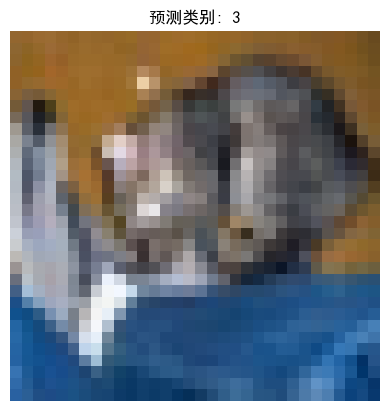

In [4]:
# 仅加载预训练权重进行一次前向推理
model = create_resnet18(pretrained=True, num_classes=10)
model.eval()

from torchvision import utils

# 从测试集取一张图片做示例预测
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:1].to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

plt.imshow(utils.make_grid(images.cpu(), normalize=True).permute(1, 2, 0))
plt.title(f"预测类别: {predicted.item()}")
plt.axis('off')
plt.show()


### CIFAR-10 类别标签
| 标签 | 类别名称 |
|---|---|
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |


/home/ubuntu24/anaconda3/envs/torch-gpu/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


已冻结特征提取层参数 (11176512/11181642)
Epoch 1/40 | Batch 100/782 | 单Batch损失: 2.0450
Epoch 1/40 | Batch 200/782 | 单Batch损失: 1.8644
Epoch 1/40 | Batch 300/782 | 单Batch损失: 1.8466
Epoch 1/40 | Batch 400/782 | 单Batch损失: 2.1444
Epoch 1/40 | Batch 500/782 | 单Batch损失: 1.7094
Epoch 1/40 | Batch 600/782 | 单Batch损失: 1.8856
Epoch 1/40 | Batch 700/782 | 单Batch损失: 1.7618
Epoch 1 完成 | 训练损失: 1.9605 | 训练准确率: 29.96% | 测试准确率: 33.74%
Epoch 2/40 | Batch 100/782 | 单Batch损失: 1.9687
Epoch 2/40 | Batch 200/782 | 单Batch损失: 1.8155
Epoch 2/40 | Batch 300/782 | 单Batch损失: 1.8060
Epoch 2/40 | Batch 400/782 | 单Batch损失: 1.5585
Epoch 2/40 | Batch 500/782 | 单Batch损失: 1.7680
Epoch 2/40 | Batch 600/782 | 单Batch损失: 2.0283
Epoch 2/40 | Batch 700/782 | 单Batch损失: 2.1210
Epoch 2 完成 | 训练损失: 1.8616 | 训练准确率: 33.88% | 测试准确率: 33.30%
Epoch 3/40 | Batch 100/782 | 单Batch损失: 1.7186
Epoch 3/40 | Batch 200/782 | 单Batch损失: 2.0149
Epoch 3/40 | Batch 300/782 | 单Batch损失: 1.7432
Epoch 3/40 | Batch 400/782 | 单Batch损失: 1.5576
Epoch 3/40 | Batch 500/78

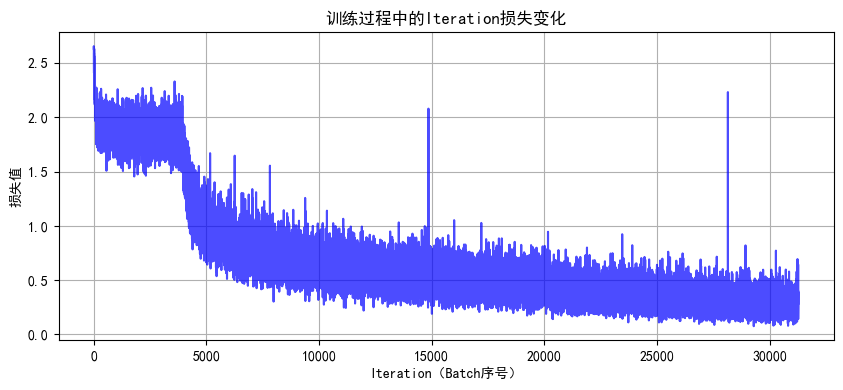

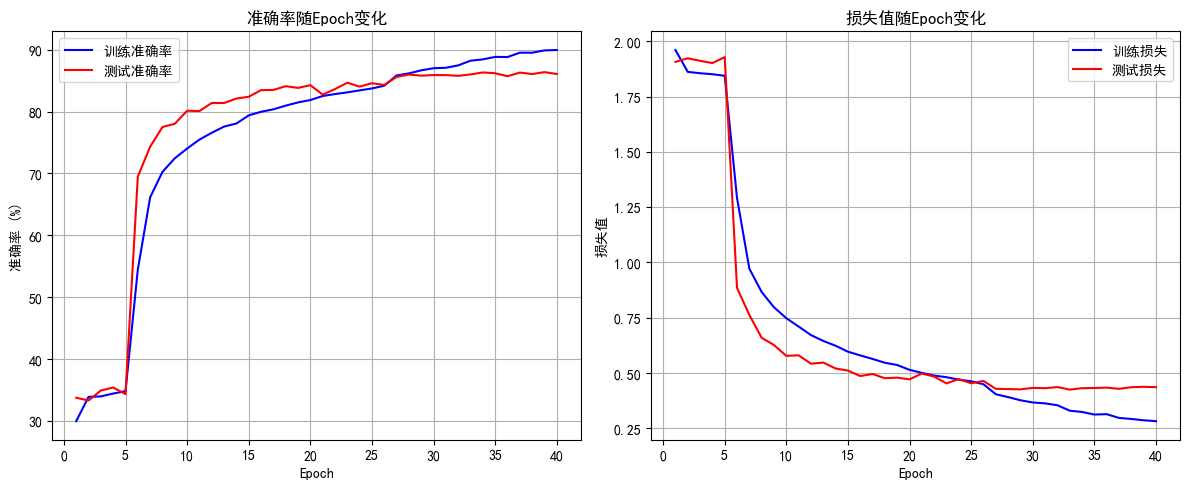

训练完成！最终测试准确率: 86.08%


In [5]:
from torchvision import models

# 冻结/解冻 backbone 的工具函数
def freeze_backbone(model, freeze=True):
    for name, param in model.named_parameters():
        if 'fc' not in name:
            param.requires_grad = not freeze

    frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    if freeze:
        print(f"已冻结特征提取层参数 ({frozen_params}/{total_params})")
    else:
        print(f"已解冻所有参数 ({total_params}/{total_params})")

    return model

# 分阶段训练：前 freeze_epochs 轮冻结，之后解冻
def train_with_freeze_schedule(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs, freeze_epochs=5):
    train_loss_history, test_loss_history = [], []
    train_acc_history, test_acc_history = [], []
    all_iter_losses, iter_indices = [], []

    if freeze_epochs > 0:
        model = freeze_backbone(model, freeze=True)

    for epoch in range(epochs):
        if epoch == freeze_epochs:
            model = freeze_backbone(model, freeze=False)
            # 解冻后降低学习率，避免大幅破坏预训练特征
            optimizer.param_groups[0]['lr'] = 1e-4

        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)

            running_loss += iter_loss
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | 单Batch损失: {iter_loss:.4f}")

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct_train / total_train

        model.eval()
        correct_test, total_test = 0, 0
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100.0 * correct_test / total_test

        train_loss_history.append(epoch_train_loss)
        test_loss_history.append(epoch_test_loss)
        train_acc_history.append(epoch_train_acc)
        test_acc_history.append(epoch_test_acc)

        if scheduler is not None:
            scheduler.step(epoch_test_loss)

        print(f"Epoch {epoch+1} 完成 | 训练损失: {epoch_train_loss:.4f} | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%")

    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)

    return epoch_test_acc

def main():
    epochs = 40
    freeze_epochs = 5
    learning_rate = 1e-3
    weight_decay = 1e-4

    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 10)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    final_accuracy = train_with_freeze_schedule(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=epochs,
        freeze_epochs=freeze_epochs
    )

    print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

if __name__ == '__main__':
    main()


## 6. 现象与结论
1. 解冻后少数几个 epoch 即可达到普通 CNN 训练更久的效果，这是预训练的优势。
2. 训练集使用数据增强，可能导致训练初期准确率暂时低于测试集。
3. 微调后的最终效果通常显著优于从零开始训练。
